---
title: "ML Methods"
author:
  - name: Mahira Ayub
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
  - name: Ava Godsy
    affiliations:
      - ref: bu
  - name: Joshua Lawrence
    affiliations:
      - ref: bu
date: today
format: 
  html:
    theme: minty
    bibliography: references.bib
    csl: csl/econometrica.csl
    toc: true
---

In [2]:
import os
# Set JAVA_HOME
os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-17'  # Update to your exact path
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"
# Stop any existing Spark sessions
SparkSession.getActiveSession() and SparkSession.getActiveSession().stop()
# Initialize Spark Session with explicit local master
spark = SparkSession.builder \
    .appName("LightcastData") \
    .master("local[*]") \
    .config("spark.driver.host", "localhost") \
    .getOrCreate()
# Load Data
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("data/lightcast_job_postings.csv")
# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")
df.printSchema()
df.show(5)

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

In [3]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Filter for valid salary data
df_clean = df.filter(
    (F.col("SALARY").isNotNull()) & 
    (F.col("SALARY") > 0) &
    (F.col("STATE_NAME").isNotNull()) &
    (F.col("TITLE_NAME").isNotNull())
)

print(f"Original dataset size: {df.count():,}")
print(f"Cleaned dataset size: {df_clean.count():,}")

# Calculate salary statistics
salary_stats = df_clean.select(
    F.mean("SALARY").alias("mean_salary"),
    F.expr("percentile_approx(SALARY, 0.5)").alias("median_salary"),
    F.stddev("SALARY").alias("std_salary"),
    F.min("SALARY").alias("min_salary"),
    F.max("SALARY").alias("max_salary")
).collect()[0]

print(f"\nSalary Statistics:")
print(f"  Mean: ${salary_stats['mean_salary']:,.2f}")
print(f"  Median: ${salary_stats['median_salary']:,.2f}")
print(f"  Std Dev: ${salary_stats['std_salary']:,.2f}")
print(f"  Min: ${salary_stats['min_salary']:,.2f}")
print(f"  Max: ${salary_stats['max_salary']:,.2f}")

# Create binary classification target (above average = 1, below average = 0)
avg_salary = salary_stats['mean_salary']
df_clean = df_clean.withColumn(
    "ABOVE_AVERAGE_SALARY",
    F.when(F.col("SALARY") > avg_salary, 1).otherwise(0)
)


Original dataset size: 72,498
Cleaned dataset size: 30,808

Salary Statistics:
  Mean: $117,953.76
  Median: $116,300.00
  Std Dev: $45,133.88
  Min: $15,860.00
  Max: $500,000.00


In [4]:
# Handle SKILLS_NAME - it may contain arrays or null values
# Extract first skill or mark as "No Skills Listed"
df_clean = df_clean.withColumn(
    "PRIMARY_SKILL",
    F.when(
        F.col("SKILLS_NAME").isNotNull(),
        F.split(F.regexp_replace(F.col("SKILLS_NAME"), r'[\[\]"\n]', ''), ",").getItem(0)
    ).otherwise("No Skills Listed")
)

# Select features and target, and clean empty strings
features_df = df_clean.select(
    "STATE_NAME",
    "TITLE_NAME", 
    "PRIMARY_SKILL",
    "SALARY",
    "ABOVE_AVERAGE_SALARY"
).withColumn(
    "STATE_NAME",
    F.when((F.col("STATE_NAME").isNull()) | (F.trim(F.col("STATE_NAME")) == ""), "Unknown")
     .otherwise(F.trim(F.col("STATE_NAME")))
).withColumn(
    "TITLE_NAME",
    F.when((F.col("TITLE_NAME").isNull()) | (F.trim(F.col("TITLE_NAME")) == ""), "Unknown")
     .otherwise(F.trim(F.col("TITLE_NAME")))
).withColumn(
    "PRIMARY_SKILL",
    F.when((F.col("PRIMARY_SKILL").isNull()) | (F.trim(F.col("PRIMARY_SKILL")) == ""), "No Skills Listed")
     .otherwise(F.trim(F.col("PRIMARY_SKILL")))
)

# Show feature distribution
print("\nTop 10 States by Job Postings:")
features_df.groupBy("STATE_NAME").count().orderBy(F.desc("count")).show(10, truncate=False)

print("\nTop 10 Job Titles by Frequency:")
features_df.groupBy("TITLE_NAME").count().orderBy(F.desc("count")).show(10, truncate=False)

print("\nTop 10 Skills by Frequency:")
features_df.groupBy("PRIMARY_SKILL").count().orderBy(F.desc("count")).show(10, truncate=False)



Top 10 States by Job Postings:
+--------------+-----+
|STATE_NAME    |count|
+--------------+-----+
|California    |3984 |
|Texas         |2544 |
|New York      |1996 |
|Florida       |1504 |
|Virginia      |1347 |
|Illinois      |1271 |
|North Carolina|962  |
|Colorado      |943  |
|Washington    |933  |
|Ohio          |927  |
+--------------+-----+
only showing top 10 rows


Top 10 Job Titles by Frequency:
+-------------------------------+-----+
|TITLE_NAME                     |count|
+-------------------------------+-----+
|Data Analysts                  |3632 |
|Business Intelligence Analysts |991  |
|Unclassified                   |976  |
|Oracle Cloud HCM Consultants   |714  |
|Enterprise Architects          |699  |
|Data Analytics Engineers       |349  |
|Data and Reporting Analysts    |319  |
|Data Governance Analysts       |288  |
|Principal Architects           |227  |
|Enterprise Solutions Architects|225  |
+-------------------------------+-----+
only showing top 10 rows




In [5]:
# String indexing for categorical variables
state_indexer = StringIndexer(inputCol="STATE_NAME", outputCol="STATE_INDEX", handleInvalid="keep")
title_indexer = StringIndexer(inputCol="TITLE_NAME", outputCol="TITLE_INDEX", handleInvalid="keep")
skill_indexer = StringIndexer(inputCol="PRIMARY_SKILL", outputCol="SKILL_INDEX", handleInvalid="keep")

# One-hot encoding
state_encoder = OneHotEncoder(inputCol="STATE_INDEX", outputCol="STATE_VEC")
title_encoder = OneHotEncoder(inputCol="TITLE_INDEX", outputCol="TITLE_VEC")
skill_encoder = OneHotEncoder(inputCol="SKILL_INDEX", outputCol="SKILL_VEC")

# Assemble features
assembler = VectorAssembler(
    inputCols=["STATE_VEC", "TITLE_VEC", "SKILL_VEC"],
    outputCol="features"
)

# Split data (80% train, 20% test)
train_data, test_data = features_df.randomSplit([0.8, 0.2], seed=42)

print(f"Training set size: {train_data.count():,}")
print(f"Test set size: {test_data.count():,}")


Training set size: 24,676
Test set size: 6,132


In [6]:
# Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="SALARY", maxIter=100, regParam=0.1)

# Create pipeline
lr_pipeline = Pipeline(stages=[
    state_indexer, title_indexer, skill_indexer,
    state_encoder, title_encoder, skill_encoder,
    assembler, lr
])

# Train the model
lr_model = lr_pipeline.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(lr_predictions)
r2 = evaluator_r2.evaluate(lr_predictions)
mae = evaluator_mae.evaluate(lr_predictions)

print(f"\nLinear Regression Model Performance:")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  R² Score: {r2:.4f}")
print(f"  MAE: ${mae:,.2f}")

# Show sample predictions
print("\nSample Predictions:")
lr_predictions.select("STATE_NAME", "TITLE_NAME", "PRIMARY_SKILL", "SALARY", "prediction").show(10, truncate=50)



Linear Regression Model Performance:
  RMSE: $31,213.94
  R² Score: 0.5332
  MAE: $21,417.79

Sample Predictions:
+----------+--------------------------------------------+-------------------+------+------------------+
|STATE_NAME|                                  TITLE_NAME|      PRIMARY_SKILL|SALARY|        prediction|
+----------+--------------------------------------------+-------------------+------+------------------+
|   Alabama|                         Analytics Engineers|        Reliability|134500|134287.38233297397|
|   Alabama|              Business Intelligence Analysts|Business Objectives|105200|  108386.078482199|
|   Alabama|              Business Intelligence Analysts|   Data Warehousing|112097|107321.68487090743|
|   Alabama|              Business Intelligence Analysts|           Power BI| 59582| 98300.68285045939|
|   Alabama|              Business Intelligence Analysts|           Research|125000|   98235.926749922|
|   Alabama|Business Intelligence and Analytics Manag

In [7]:
# Logistic Regression model
log_reg = LogisticRegression(featuresCol="features", labelCol="ABOVE_AVERAGE_SALARY", maxIter=100)

# Create pipeline
log_pipeline = Pipeline(stages=[
    state_indexer, title_indexer, skill_indexer,
    state_encoder, title_encoder, skill_encoder,
    assembler, log_reg
])

# Train the model
log_model = log_pipeline.fit(train_data)

# Make predictions
log_predictions = log_model.transform(test_data)

# Evaluate classification model
auc_evaluator = BinaryClassificationEvaluator(labelCol="ABOVE_AVERAGE_SALARY", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(log_predictions)

# Calculate accuracy
accuracy = log_predictions.filter(
    F.col("ABOVE_AVERAGE_SALARY") == F.col("prediction")
).count() / log_predictions.count()

print(f"\nLogistic Regression Model Performance:")
print(f"  AUC-ROC: {auc:.4f}")
print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Confusion Matrix
print("\nConfusion Matrix:")
confusion_matrix = log_predictions.groupBy("ABOVE_AVERAGE_SALARY", "prediction").count()
confusion_matrix.orderBy("ABOVE_AVERAGE_SALARY", "prediction").show()



Logistic Regression Model Performance:
  AUC-ROC: 0.8779
  Accuracy: 0.8081 (80.81%)

Confusion Matrix:
+--------------------+----------+-----+
|ABOVE_AVERAGE_SALARY|prediction|count|
+--------------------+----------+-----+
|                   0|       0.0| 2665|
|                   0|       1.0|  485|
|                   1|       0.0|  692|
|                   1|       1.0| 2290|
+--------------------+----------+-----+



In [8]:

# Extract the trained linear regression model
trained_lr = lr_model.stages[-1]
coefficients = trained_lr.coefficients
intercept = trained_lr.intercept

print(f"Model Intercept: ${intercept:,.2f}")
print(f"Number of features: {len(coefficients)}")
print(f"Sum of coefficients: {sum(coefficients):,.2f}")


Model Intercept: $117,965.27
Number of features: 4219
Sum of coefficients: -34,383,304.02


In [12]:
pred_data = lr_predictions.select("SALARY", "prediction", "STATE_NAME", "TITLE_NAME").limit(1000).collect()
pred_sample = pd.DataFrame(pred_data, columns=["SALARY", "prediction", "STATE_NAME", "TITLE_NAME"])

fig1 = px.scatter(
    pred_sample, 
    x="SALARY", 
    y="prediction",
    title="Actual vs Predicted Salary (Linear Regression)",
    labels={"SALARY": "Actual Salary ($)", "prediction": "Predicted Salary ($)"},
    opacity=0.6,
    hover_data=["STATE_NAME", "TITLE_NAME"],
    color_discrete_sequence=['#78C2AD']
)
fig1.add_trace(go.Scatter(
    x=[pred_sample["SALARY"].min(), pred_sample["SALARY"].max()],
    y=[pred_sample["SALARY"].min(), pred_sample["SALARY"].max()],
    mode='lines',
    name='Perfect Prediction',
    line=dict(color='red', dash='dash')
))
fig1.update_layout(
    font=dict(
        family="Verdana",
        size=14,
        color="black"
    ),
    title=dict(
        font=dict(
            family="Verdana",
            size=18,
            color="black"
        )
    ),
    xaxis=dict(
        title_font=dict(
            family="Verdana",
            size=14,
            color="black"
        )
    ),
    yaxis=dict(
        title_font=dict(
            family="Verdana",
            size=14,
            color="black"
        )
    )
)
fig1.show()


state_salary_data = df_clean.groupBy("STATE_NAME").agg(
    F.mean("SALARY").alias("avg_salary"),
    F.count("SALARY").alias("job_count")
).orderBy(F.desc("avg_salary")).limit(10).collect()
state_salary = pd.DataFrame(state_salary_data, columns=["STATE_NAME", "avg_salary", "job_count"])

fig2 = px.bar(
    state_salary,
    x="STATE_NAME",
    y="avg_salary",
    title="Top 10 States by Average Salary",
    labels={"STATE_NAME": "State", "avg_salary": "Average Salary ($)"},
    color="avg_salary",
    text="job_count",
    color_continuous_scale=px.colors.sequential.Mint
)
fig2.update_traces(texttemplate='Jobs: %{text}', textposition='outside')
fig2.update_layout(
    font=dict(
        family="Verdana",
        size=14,
        color="black"
    ),
    title=dict(
        font=dict(
            family="Verdana",
            size=18,
            color="black"
        )
    ),
    xaxis=dict(
        title_font=dict(
            family="Verdana",
            size=14,
            color="black"
        )
    ),
    yaxis=dict(
        title_font=dict(
            family="Verdana",
            size=14,
            color="black"
        )
    )
)
fig2.show()


salary_class_data = log_predictions.groupBy("ABOVE_AVERAGE_SALARY").count().collect()
salary_class = pd.DataFrame(salary_class_data, columns=["ABOVE_AVERAGE_SALARY", "count"])
salary_class["Category"] = salary_class["ABOVE_AVERAGE_SALARY"].map({0: "Below Average", 1: "Above Average"})

fig3 = px.pie(
    salary_class,
    values="count",
    names="Category",
    title="Distribution of Above/Below Average Salaries",
    color_discrete_sequence=["#78C2AD", "#F3969A"]
)
fig3.update_layout(
    font=dict(
        family="Verdana",
        size=14,
        color="black"
    ),
    title=dict(
        font=dict(
            family="Verdana",
            size=18,
            color="black"
        )
    ),
    xaxis=dict(
        title_font=dict(
            family="Verdana",
            size=14,
            color="black"
        )
    ),
    yaxis=dict(
        title_font=dict(
            family="Verdana",
            size=14,
            color="black"
        )
    )
)
fig3.show()


title_salary_data = df_clean.groupBy("TITLE_NAME").agg(
    F.mean("SALARY").alias("avg_salary"),
    F.count("SALARY").alias("count")
).filter(F.col("count") > 5).orderBy(F.desc("avg_salary")).limit(15).collect()
title_salary = pd.DataFrame(title_salary_data, columns=["TITLE_NAME", "avg_salary", "count"])

fig4 = px.bar(
    title_salary,
    x="avg_salary",
    y="TITLE_NAME",
    orientation='h',
    title="Top 15 Job Titles by Average Salary (min 5 postings)",
    labels={"TITLE_NAME": "Job Title", "avg_salary": "Average Salary ($)"},
    color="avg_salary",
    color_continuous_scale=px.colors.sequential.Mint
)
fig4.update_layout(
    font=dict(
        family="Verdana",
        size=14,
        color="black"
    ),
    title=dict(
        font=dict(
            family="Verdana",
            size=18,
            color="black"
        )
    ),
    xaxis=dict(
        title_font=dict(
            family="Verdana",
            size=14,
            color="black"
        )
    ),
    yaxis=dict(
        title_font=dict(
            family="Verdana",
            size=14,
            color="black"
        )
    )
)
fig4.show()

predictions_data = lr_predictions.select(
    "STATE_NAME", "TITLE_NAME", "PRIMARY_SKILL", 
    "SALARY", "prediction", "ABOVE_AVERAGE_SALARY"
).limit(10000).collect()  

predictions_pdf = pd.DataFrame(
    predictions_data, 
    columns=["STATE_NAME", "TITLE_NAME", "PRIMARY_SKILL", "SALARY", "prediction", "ABOVE_AVERAGE_SALARY"]
)
predictions_pdf.to_csv("output/salary_predictions.csv", index=False)
print(f"Results saved to: output/salary_predictions.csv ({len(predictions_pdf):,} rows)")

Results saved to: output/salary_predictions.csv (6,132 rows)


In [9]:
import pandas as pd

# Load data
df = pd.read_csv("lightcast_job_postings.csv")

# View column names
print(df.columns)

C:\Users\mahir\AppData\Local\Temp\ipykernel_9668\1144677925.py:4: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("lightcast_job_postings.csv")


Index(['ID', 'LAST_UPDATED_DATE', 'LAST_UPDATED_TIMESTAMP', 'DUPLICATES',
       'POSTED', 'EXPIRED', 'DURATION', 'SOURCE_TYPES', 'SOURCES', 'URL',
       ...
       'NAICS_2022_2', 'NAICS_2022_2_NAME', 'NAICS_2022_3',
       'NAICS_2022_3_NAME', 'NAICS_2022_4', 'NAICS_2022_4_NAME',
       'NAICS_2022_5', 'NAICS_2022_5_NAME', 'NAICS_2022_6',
       'NAICS_2022_6_NAME'],
      dtype='object', length=131)


C:\Users\mahir\AppData\Local\Temp\ipykernel_9668\1871390527.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="SKILLS_LIST", x="Count", data=top10, palette="mako")


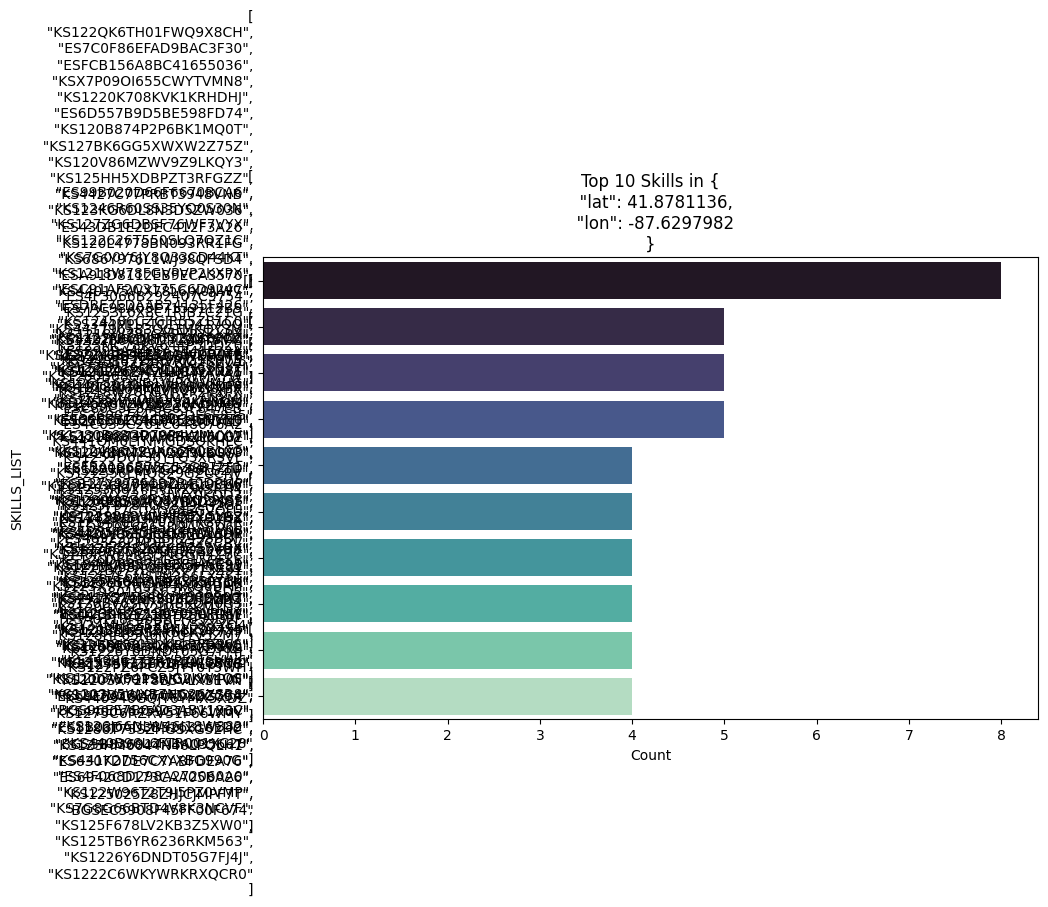

C:\Users\mahir\AppData\Local\Temp\ipykernel_9668\1871390527.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="SKILLS_LIST", x="Count", data=top10, palette="mako")


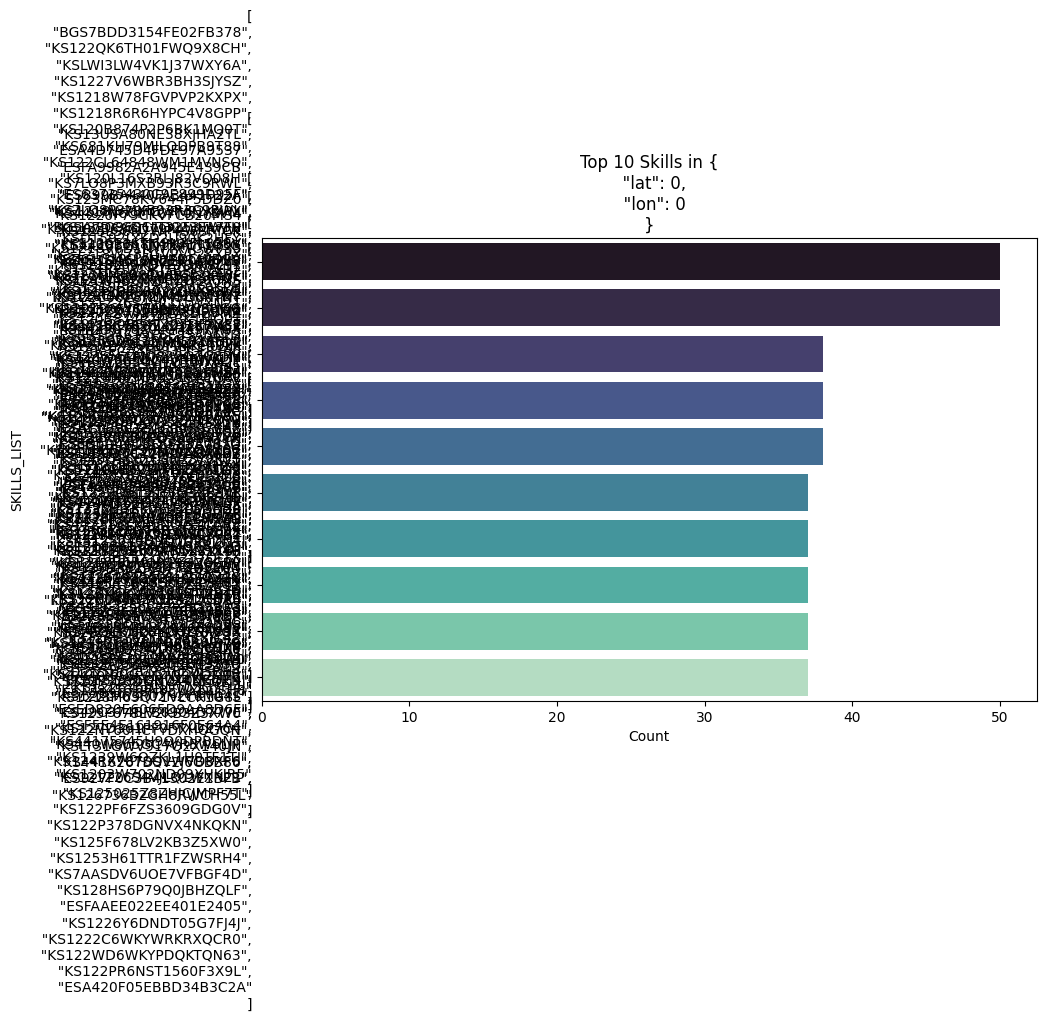

C:\Users\mahir\AppData\Local\Temp\ipykernel_9668\1871390527.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="SKILLS_LIST", x="Count", data=top10, palette="mako")


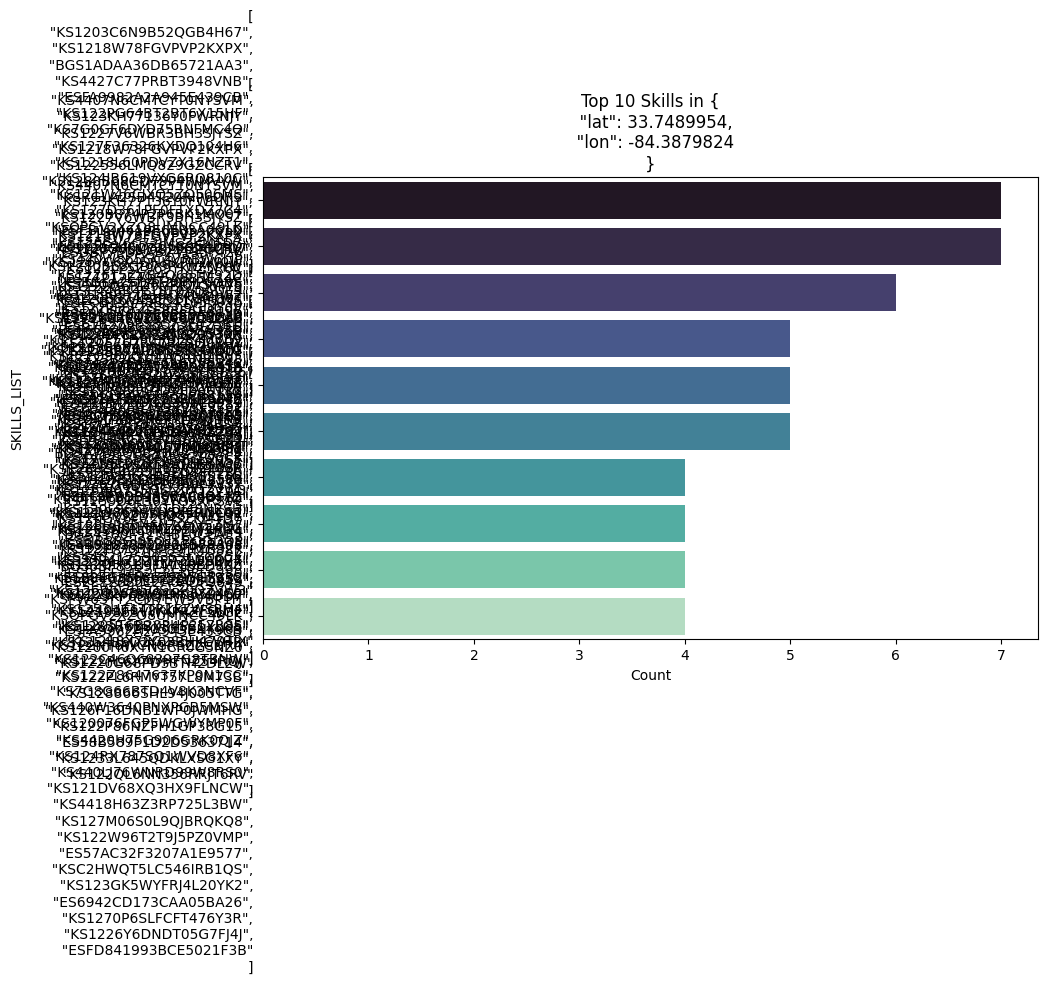

C:\Users\mahir\AppData\Local\Temp\ipykernel_9668\1871390527.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="SKILLS_LIST", x="Count", data=top10, palette="mako")


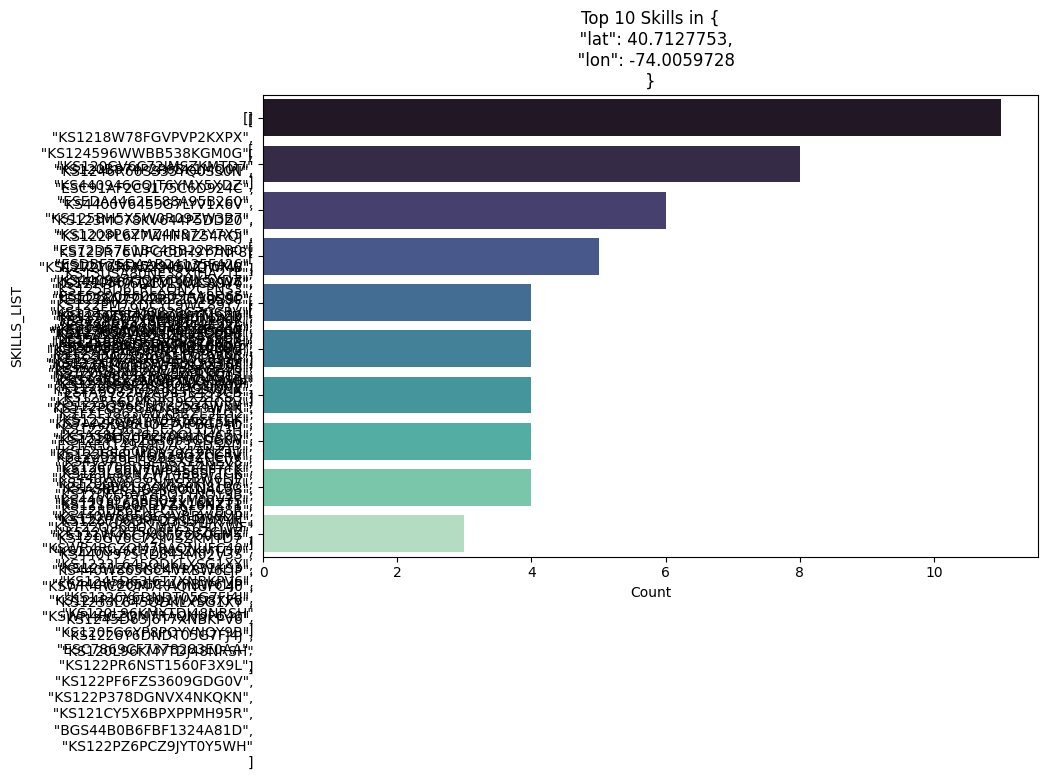

C:\Users\mahir\AppData\Local\Temp\ipykernel_9668\1871390527.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="SKILLS_LIST", x="Count", data=top10, palette="mako")


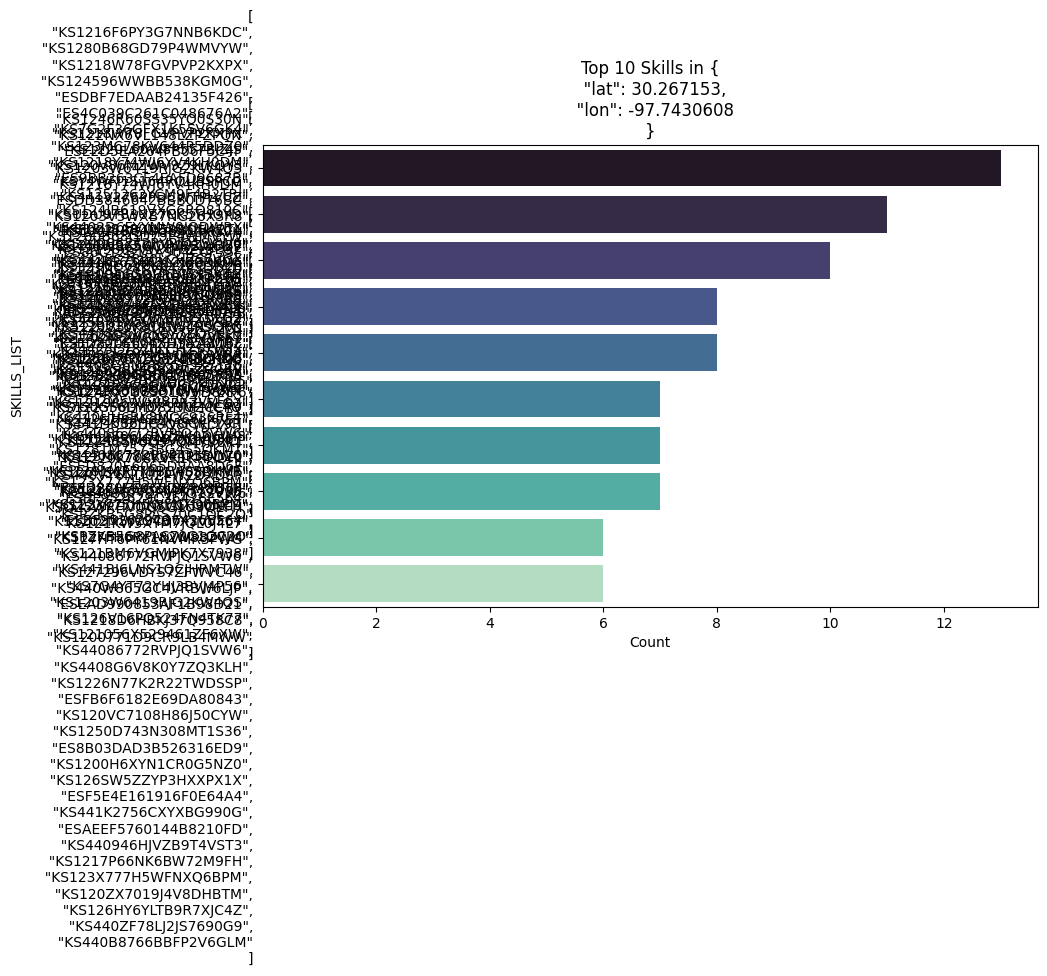

In [31]:
# Explode into one skill per row (reuse skills_exploded)
skills_loc = df.explode("SKILLS_LIST")

# Count top skills per location
top_loc_skills = (
    skills_loc.groupby(["LOCATION", "SKILLS_LIST"])
    .size()
    .reset_index(name="Count")
)

# Plot top 10 for top 5 locations
top_locations = df["LOCATION"].value_counts().nlargest(5).index

for loc in top_locations:
    top10 = (
        top_loc_skills[top_loc_skills["LOCATION"] == loc]
        .nlargest(10, "Count")
    )
    
    plt.figure(figsize=(10,6))
    sns.barplot(y="SKILLS_LIST", x="Count", data=top10, palette="mako")
    plt.title(f"Top 10 Skills in {loc}")
    plt.show()
